In [1]:
%matplotlib inline


# 9 - Initiators & Deleters
So far we have provided a prior in all our examples, defining where we think our tracks will start.
This has also been for a fixed number of tracks. In practice, targets may appear and disappear
all the time. This could be because they enter/exit the sensor's field of view.
The location/state of the targets' birth may also be unknown and varying.


## Simulating multiple targets
Here we'll simulate multiple targets moving at a constant velocity. A Poisson distribution will
be used to sample the number of new targets which are born at a particular timestep, and a simple
draw from a uniform distribution will be used to decide if a target will be removed. Each target
will have a random position and velocity on birth.



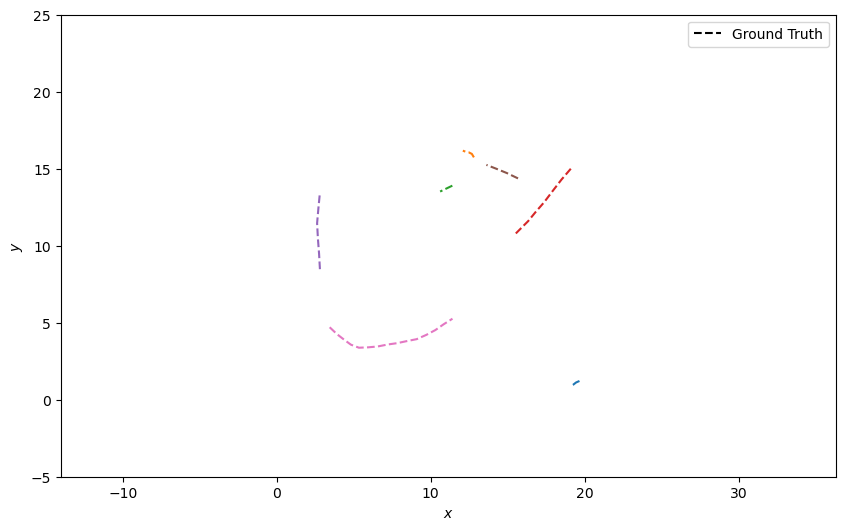

In [2]:
from datetime import datetime
from datetime import timedelta

import numpy as np

from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

np.random.seed(1991)

start_time = datetime.now()
truths = set()  # Truths across all time
current_truths = set()  # Truths alive at current time

transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.005),
                                                          ConstantVelocity(0.005)])

for k in range(20):
    # Death
    for truth in current_truths.copy():
        if np.random.rand() <= 0.05:  # Death probability
            current_truths.remove(truth)
    # Update truths
    for truth in current_truths:
        truth.append(GroundTruthState(
            transition_model.function(truth[-1], noise=True, time_interval=timedelta(seconds=1)),
            timestamp=start_time + timedelta(seconds=k)))
    # Birth
    for _ in range(np.random.poisson(0.6)):  # Birth probability
        x, y = initial_position = np.random.rand(2) * [20, 20]  # Range [0, 20] for x and y
        x_vel, y_vel = (np.random.rand(2))*2 - 1  # Range [-1, 1] for x and y velocity
        state = GroundTruthState([x, x_vel, y, y_vel], timestamp=start_time + timedelta(seconds=k))

        # Add to truth set for current and for all timestamps
        truth = GroundTruthPath([state])
        current_truths.add(truth)
        truths.add(truth)

from stonesoup.plotter import Plotter
plotter = Plotter()
plotter.ax.set_ylim(-5, 25)
plotter.plot_ground_truths(truths, [0, 2])

## Generate Detections and Clutter
Next, generate detections with clutter just as in the previous tutorials, skipping over the truth
paths that weren't alive at the current time step.



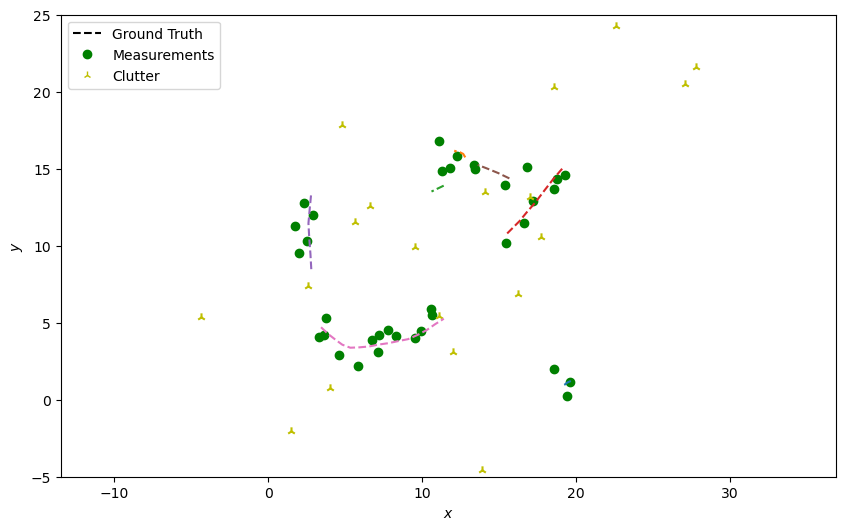

In [3]:
from scipy.stats import uniform
from stonesoup.types.detection import TrueDetection
from stonesoup.types.detection import Clutter
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.array([[0.25, 0],
                          [0, 0.25]])
    )
all_measurements = []

for k in range(20):
    measurement_set = set()
    timestamp = start_time + timedelta(seconds=k)

    for truth in truths:
        try:
            truth_state = truth[timestamp]
        except IndexError:
            # This truth not alive at this time.
            continue
        # Generate actual detection from the state with a 10% chance that no detection is received.
        if np.random.rand() <= 0.9:
            # Generate actual detection from the state
            measurement = measurement_model.function(truth_state, noise=True)
            measurement_set.add(TrueDetection(state_vector=measurement,
                                              groundtruth_path=truth,
                                              timestamp=truth_state.timestamp,
                                              measurement_model=measurement_model))

            # Generate clutter at this time-step
            truth_x = truth_state.state_vector[0]
            truth_y = truth_state.state_vector[2]
            for _ in range(np.random.randint(2)):
                x = uniform.rvs(truth_x - 10, 20)
                y = uniform.rvs(truth_y - 10, 20)
                measurement_set.add(Clutter(np.array([[x], [y]]), timestamp=timestamp,
                                            measurement_model=measurement_model))
    all_measurements.append(measurement_set)

# Plot true detections and clutter.
plotter.plot_measurements(all_measurements, [0, 2], color='g')
plotter.fig

## Creating a Tracker
We'll now create the tracker components as we did with the multi-target examples previously.



In [4]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=3)

from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
data_associator = GNNWith2DAssignment(hypothesiser)

## Creating a Deleter
Here we are going to create an error based deleter, which will delete any :class:`~.Track` where
trace of the covariance is over a certain threshold, i.e. when we have a high uncertainty. This
simply requires a threshold to be defined, which will depend on units and number of dimensions of
your state vector. So the higher the threshold value, the longer tracks that haven't been
updated will remain.



In [5]:
from stonesoup.deleter.error import CovarianceBasedDeleter
deleter = CovarianceBasedDeleter(covar_trace_thresh=4)

## Creating an Initiator
Here we are going to use a measurement based initiator, which will create a track from the
unassociated :class:`~.Detection` objects. A prior needs to be defined for the entire state
but elements of the state that are measured are replaced by state of the measurement, including
the measurement's uncertainty (noise covariance defined by the :class:`~.MeasurementModel`). In
this example, as our sensor measures position (as defined in measurement model
:attr:`~.LinearGaussian.mapping` attribute earlier), we only need to modify the values for the
velocity and its variance.

As we are dealing with clutter, here we are going to be using a multi-measurement initiator. This
requires that multiple measurements are added to a track before being initiated. In this example,
this initiator effectively runs a mini version of the same tracker, but you could use different
components.



In [6]:
from stonesoup.types.state import GaussianState
from stonesoup.initiator.simple import MultiMeasurementInitiator
initiator = MultiMeasurementInitiator(
    prior_state=GaussianState([[0], [0], [0], [0]], np.diag([0, 1, 0, 1])),
    measurement_model=measurement_model,
    deleter=deleter,
    data_associator=data_associator,
    updater=updater,
    min_points=2,
    )

## Running the Tracker
Loop through the predict, hypothesise, associate and update steps like before, but note on update
which detections we've used at each time step. In each loop the deleter is called, returning
tracks that are to be removed. Then the initiator is called with the unassociated detections, by
removing the associated detections from the full set. The order of the deletion and initiation is
important, so tracks that have just been created, aren't deleted straight away. (The
implementation below is the same as :class:`~.MultiTargetTracker`)



In [7]:
tracks, all_tracks = set(), set()

for n, measurements in enumerate(all_measurements):
    # Calculate all hypothesis pairs and associate the elements in the best subset to the tracks.
    hypotheses = data_associator.associate(tracks,
                                           measurements,
                                           start_time + timedelta(seconds=n))
    associated_measurements = set()
    for track in tracks:
        hypothesis = hypotheses[track]
        if hypothesis.measurement:
            post = updater.update(hypothesis)
            track.append(post)
            associated_measurements.add(hypothesis.measurement)
        else:  # When data associator says no detections are good enough, we'll keep the prediction
            track.append(hypothesis.prediction)

    # Carry out deletion and initiation
    tracks -= deleter.delete_tracks(tracks)
    tracks |= initiator.initiate(measurements - associated_measurements,
                                 start_time + timedelta(seconds=n))
    all_tracks |= tracks

Plot the resulting tracks.



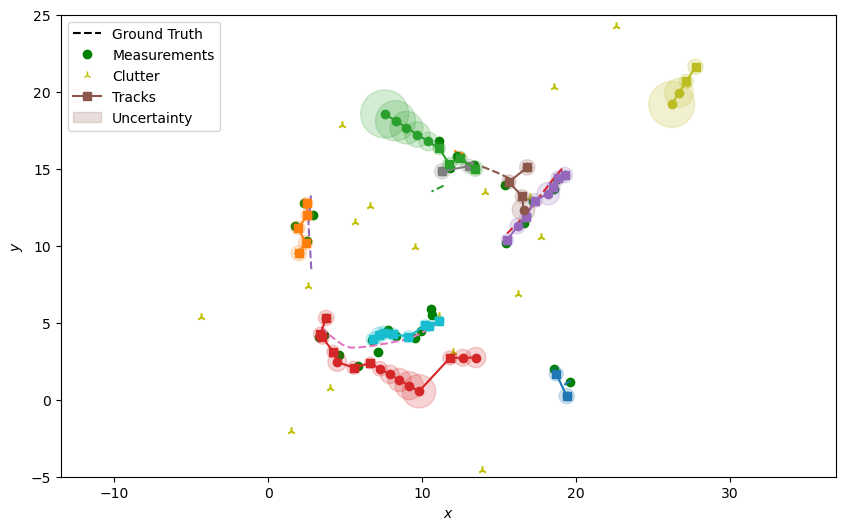

In [8]:
plotter.plot_tracks(all_tracks, [0, 2], uncertainty=True)
plotter.fig